In [12]:
import numpy as np
import cv2
from keras.models import load_model

In [13]:
# Load the saved model
model = load_model('model_rafdb.h5')

In [14]:
# Emotion labels for FER 2013 dataset
emotion_labels = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']

In [15]:
face_detection = cv2.CascadeClassifier('haar_cascade_face_detection.xml')

settings = {
	'scaleFactor': 1.3, 
	'minNeighbors': 5, 
	'minSize': (50, 50)
}

In [16]:
def preprocess_image(image_path, face_detection, settings):
    # Load image in color
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or unable to load.")

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    detected_faces = face_detection.detectMultiScale(gray, **settings)

    if len(detected_faces) == 0:
        raise ValueError("No faces detected in the image.")

    # Process only the first detected face (optional: handle multiple faces)
    x, y, w, h = detected_faces[0]

    # Crop the detected face
    face = gray[y + 5:y + h - 5, x + 20:x + w - 20]
    # Resize face to 48x48
    face = cv2.resize(face, (48, 48))
    # Normalize pixel values
    face = face / 255.0
    # Expand dimensions to match model input shape (1, 48, 48, 1)
    face = np.expand_dims(face, axis=-1)  # Add channel dimension
    face = np.expand_dims(face, axis=0)  # Add batch dimension

    return face

In [17]:
def predict_emotion(image_path):
    try:
        # Preprocess the image
        processed_img = preprocess_image(image_path, face_detection, settings)

        # Validate processed image shape
        if processed_img is None or len(processed_img.shape) != 4:
            raise ValueError(f"Invalid processed image shape: {processed_img.shape if processed_img is not None else 'None'}")

        # Debugging shapes
        print(f"Processed image shape: {processed_img.shape}")
        print(f"Expected model input shape: {model.input_shape}")

        # Get prediction
        prediction = model.predict(processed_img)

        # Debugging prediction output
        print(f"Prediction output: {prediction}")

        # Get the index of the highest probability
        emotion_idx = np.argmax(prediction)
        # Get the corresponding label
        emotion = emotion_labels[emotion_idx]

        return emotion
    except Exception as e:
        print(f"Error during emotion prediction: {e}")
        return None

In [18]:
def predict_emotion_with_probabilities(image_path):
    try:
        # Preprocess the image
        processed_img = preprocess_image(image_path, face_detection, settings)
        
        if processed_img is None or len(processed_img.shape) != 4:
            raise ValueError(f"Invalid input shape: {processed_img.shape if processed_img is not None else 'None'}")

        # Print input shape for debugging
        print(f"Processed image shape: {processed_img.shape}")
        print(f"Model expected input shape: {model.input_shape}")

        # Get prediction probabilities for all classes
        predictions = model.predict(processed_img)[0]  # [0] to flatten the batch dimension
        
        # Get the index of the highest probability
        emotion_idx = np.argmax(predictions)
        # Get the corresponding label
        emotion = emotion_labels[emotion_idx]
        # Display probabilities for each class
        probabilities = {emotion_labels[i]: predictions[i] for i in range(len(emotion_labels))}
        return emotion, probabilities
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

Processed image shape: (1, 48, 48, 1)
Model expected input shape: (None, 48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
The predicted emotion is: Happy
Class probabilities:
Happy: 1.0000
Neutral: 0.0000
Angry: 0.0000
Fear: 0.0000
Disgust: 0.0000
Sad: 0.0000
Surprise: 0.0000


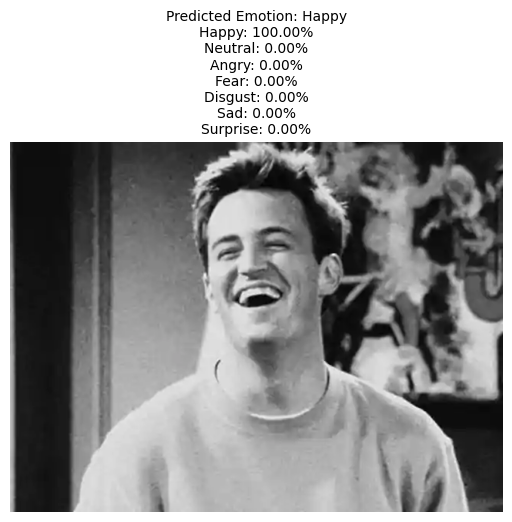

In [19]:
import matplotlib.pyplot as plt
from PIL import Image

# Define the path to the image
image_path = 'test.jpg'

# Get the predicted emotion and class probabilities
predicted_emotion, class_probabilities = predict_emotion_with_probabilities(image_path)

if predicted_emotion:
    print(f"The predicted emotion is: {predicted_emotion}")
    print("Class probabilities:")

    # Sort emotions by their probabilities in descending order
    sorted_probabilities = sorted(class_probabilities.items(), key=lambda x: x[1], reverse=True)
    
    # Print the sorted probabilities
    for emotion, prob in sorted_probabilities:
        print(f"{emotion}: {prob:.4f}")
    
    # Display the image along with the labels
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  # Hide the image axes
    
    # Prepare text for annotations (emotions and probabilities as percentages)
    annotations = "\n".join([f"{emotion}: {prob:.2%}" for emotion, prob in sorted_probabilities])
    
    # Add title to the image
    plt.title(f"Predicted Emotion: {predicted_emotion}\n{annotations}", fontsize=10)
    plt.show()
else:
    print("Prediction failed.")

Processed image shape: (1, 48, 48, 1)
Expected model input shape: (None, 48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction output: [[5.6499601e-07 1.9021378e-06 1.1638152e-06 9.9998081e-01 9.8611804e-07
  2.5088832e-06 1.2030081e-05]]
The predicted emotion is: Happy


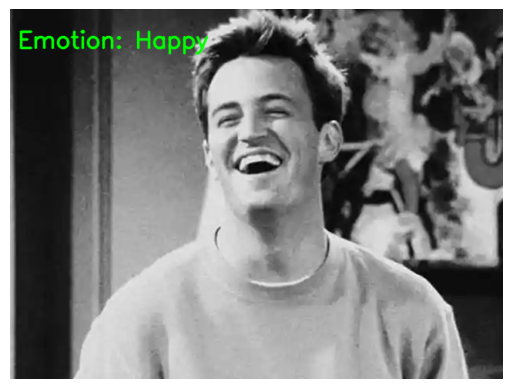

In [20]:
import cv2
import matplotlib.pyplot as plt

# Example usage
image_path = 'test.jpg'
predicted_emotion = predict_emotion(image_path)

if predicted_emotion:
    print(f"The predicted emotion is: {predicted_emotion}")
    
    # Load and display the image with the predicted emotion
    image = cv2.imread(image_path)
    if image is not None:
        # Convert BGR image to RGB for displaying with matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Add text to the image
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = f"Emotion: {predicted_emotion}"
        org = (10, 50)  # Position for the text
        font_scale = 1
        color = (0, 255, 0)  # Green color
        thickness = 2
        image_with_text = cv2.putText(image_rgb, text, org, font, font_scale, color, thickness, cv2.LINE_AA)
        
        # Display the image
        plt.imshow(image_with_text)
        plt.axis('off')  # Hide axes
        plt.show()
    else:
        print("Failed to load the image.")
else:
    print("Failed to predict emotion.")